In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import torch.optim as optim

In [3]:
import sys
sys.path.append('../../utils/')

In [4]:
from Bias_Variance_Estimator import estimate_bias_variance_mse

In [5]:
def generate_sinusoid_data(num_samples:int,noise_scale:float=0.3):
    X = np.linspace(-1,1,num_samples).reshape(-1, 1)
    y_true = np.sin(2 * np.pi * X)                       # shape: (num_samples, 1)
    noise = np.random.normal(0, noise_scale, size=(num_samples, 1))#random gaussian noise
    y = y_true + noise
    return X,y

In [6]:
NUM_TRAIN_SAMPLES = 5000
NUM_TEST_SAMPLES = 1000
BOOTSTRAP_NUMS = 20
MAX_EPOCHS = 500
PATIENCE = 500
LEARNING_RATE=0.001

In [21]:
import torch
import torch.nn as nn


class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, depth, out_dim=1,use_batchnorm=False):
        super(MLPRegressor,self).__init__()
        layers = []

        for i in range(depth):
            in_dim = input_dim if i == 0 else hidden_dim
            layers.append(nn.Linear(in_dim, hidden_dim))
            
            # He initialization
            nn.init.kaiming_normal_(layers[-1].weight, nonlinearity='relu')
            nn.init.zeros_(layers[-1].bias)

            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_dim, out_dim))
        nn.init.kaiming_normal_(layers[-1].weight, nonlinearity='linear')
        nn.init.zeros_(layers[-1].bias)

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [22]:
X_train,y_train = generate_sinusoid_data(num_samples=NUM_TRAIN_SAMPLES)
X_test,y_test = generate_sinusoid_data(num_samples=NUM_TEST_SAMPLES,noise_scale=0)

In [23]:
depths = [1,4,8,16,32,64]

In [25]:
hidden_units=128
depth_results= []
for d in depths:
    print(f"\n*** Running experiment for network with {d} depth***")
    bias_sq, variance, total_error,error_sum,avg_train_loss = estimate_bias_variance_mse(
            model_class=MLPRegressor,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            loss_fn=nn.MSELoss(),
            model_kwargs={'input_dim':X_train.shape[1],"hidden_dim":128,'depth':d},
            num_models=BOOTSTRAP_NUMS,
            max_epochs=MAX_EPOCHS,
            patience=PATIENCE,
            lr=LEARNING_RATE,
            batch_size=128
        )
    depth_results.append({
            'depth': d,
            'bias_sq': bias_sq,
            'variance': variance,
            'total_error': total_error,
            'error_sum': error_sum,
            'avg_train_loss':avg_train_loss
        })



*** Running experiment for network with 1 depth***
Starting experiment with 20 models...

--- Training Model 1/20 ---

--- Training Model 2/20 ---

--- Training Model 3/20 ---

--- Training Model 4/20 ---

--- Training Model 5/20 ---

--- Training Model 6/20 ---

--- Training Model 7/20 ---

--- Training Model 8/20 ---

--- Training Model 9/20 ---

--- Training Model 10/20 ---

--- Training Model 11/20 ---

--- Training Model 12/20 ---

--- Training Model 13/20 ---

--- Training Model 14/20 ---

--- Training Model 15/20 ---

--- Training Model 16/20 ---

--- Training Model 17/20 ---

--- Training Model 18/20 ---

--- Training Model 19/20 ---

--- Training Model 20/20 ---

--- Final Results ---
Bias:    0.1397
Variance: 0.0008
Total error: 0.1404
Bias² + Variance: 0.1404

*** Running experiment for network with 4 depth***
Starting experiment with 20 models...

--- Training Model 1/20 ---

--- Training Model 2/20 ---

--- Training Model 3/20 ---

--- Training Model 4/20 ---

--- Trainin

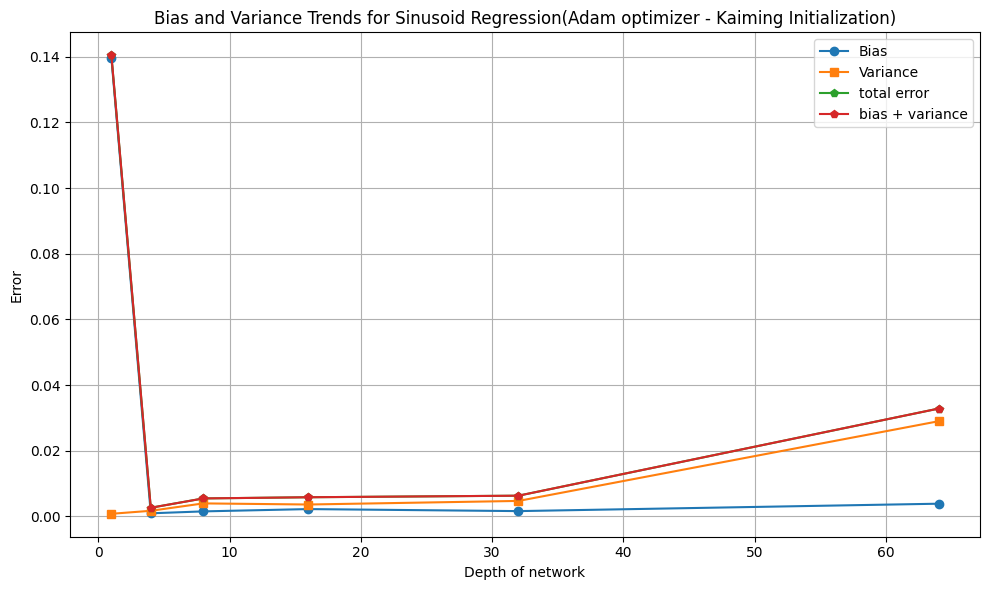

In [30]:
bias_values = [res['bias_sq'] for res in depth_results]
variance_values = [res['variance'] for res in depth_results]
error_values = [res['total_error'] for res in depth_results]
bias_plus_variance = [res['error_sum'] for res in depth_results]
    
plt.figure(figsize=(10, 6))
plt.plot(depths, bias_values, marker='o', label='Bias')
plt.plot(depths, variance_values, marker='s', label='Variance')
plt.plot(depths, error_values, marker='p', label='total error')
plt.plot(depths, bias_plus_variance, marker='p', label='bias + variance')

    
# plt.xscale('log')
plt.xlabel('Depth of network')
plt.ylabel('Error')
plt.title('Bias and Variance Trends for Sinusoid Regression(Adam optimizer - Kaiming Initialization)')
plt.legend()
plt.grid(True)
plt.tight_layout()

Text(0.5, 1.0, 'Bias and Variance Trends for Sinusoid Regression(Adam optimizer - Kaiming Initialization)')

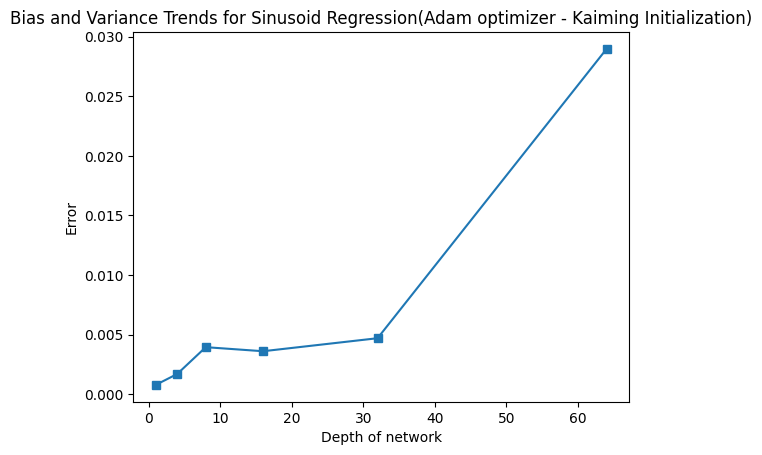

In [31]:
plt.plot(depths, variance_values, marker='s', label='Variance')
# plt.xscale('log')
plt.xlabel('Depth of network')
plt.ylabel('Error')
plt.title('Bias and Variance Trends for Sinusoid Regression(Adam optimizer - Kaiming Initialization)')

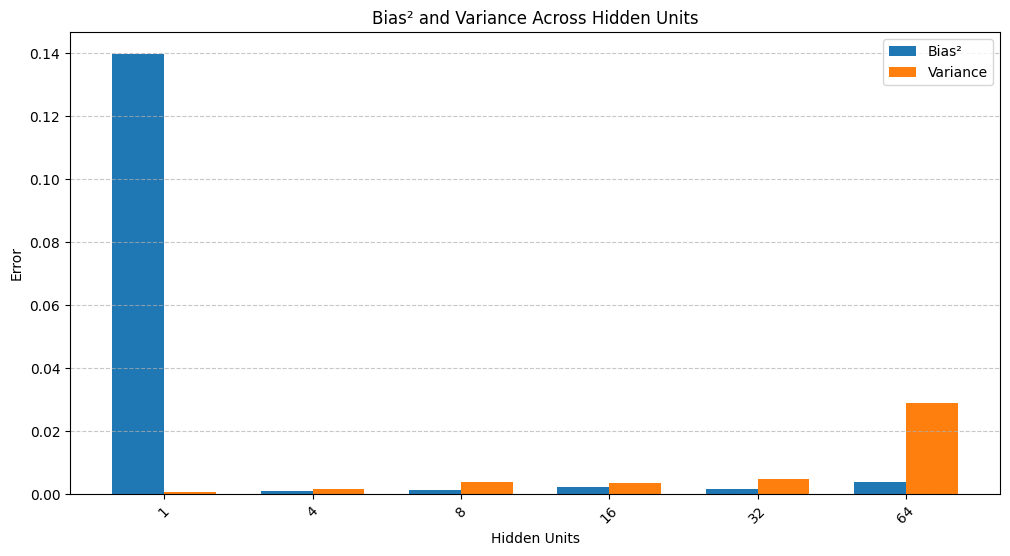

In [33]:
bias_sq = [r['bias_sq'] for r in depth_results]
variance = [r['variance'] for r in depth_results]


x = np.arange(len(depths))  
width = 0.35  
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, bias_sq, width, label='Bias²')
plt.bar(x + width/2, variance, width, label='Variance')


plt.xticks(x, depths, rotation=45)
plt.xlabel('Hidden Units')
plt.ylabel('Error')
plt.title('Bias² and Variance Across Hidden Units')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [1]:
from biasvariance_toolkit import estimate_bias_variance_mse